This project uses synthetic generated data from https://infinity.ai/ \
Github https://github.com/toinfinityai/infinity-datasets/tree/main 


#### Parameters
num_reps:  Number of exercise repetitions in the returned time series data.\
watch_location:  Wrist where device is placed (left or right).\
crown_orientation:  Which side the watch crown points (from first-person perspective; left or right).\
ref_xy_rotation:  Rotation (in XY plane) of the reference orientation in radians (simulates the xArbitraryZVertical reference in the Apple CoreMotion SDK).\
rel_baseline_speed:  Baseline speed of animation, relative to default (natural) speed.\
max_rel_speed_change:  Maximum speed change introduced, relative to baseline speed.\
trim_start_frac:  Fraction of seed animation (from start to midpoint) to truncate at the start.\
trim_end_frac:  Fraction of seed animation (from start to midpoint) to truncate at the end.\
kinematic_noise_factor:  Scaling factor used to adjust the amount of kinematic noise added in the simulated movement.\
wrist_offset_deg:  Fixed rotation offset applied to the supination/pronation axis of the wrists, in degrees. Negative values correspond to supination.\
randomize_body_shape:  If True, the avatar's body shape is randomized.\
frames_per_second:  Sampling rate of exported time series and video.\
image_width:  Width dimension of the rendered video, in pixels.\
image_height:  Height dimension of the rendered video, in pixels.


In [82]:
import pandas as pd
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
#pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [27]:
#function for retrieving multiple csv/json files

import glob
import pandas as pd
import json
from pandas import json_normalize
import os
import numpy as np

def create_combined_dataframe(directory):
    """
    Create a combined DataFrame for each set of CSV and JSON files in the specified directory.

    Parameters:
    - directory (str): The directory containing CSV and JSON files.

    Returns:
    - List[pd.DataFrame]: A list of DataFrames where each DataFrame combines CSV and JSON data, with each parameter in the JSON file having its own column.
    """
    combined_dfs = []
    
    # creates list of file names matching the pattern '*.csv' in the specified directory
    csv_files = glob.glob(f'{directory}/*.csv')

    # Process each CSV file
    for csv_file in csv_files:
        csv_df = pd.read_csv(csv_file, index_col=0)
        
        #creating column assigning rep numbers
        csv_df['rep_num'] = np.floor(csv_df['rep_count_from_start']+1).astype(int)

        # json file path
        json_file = os.path.splitext(csv_file)[0] + '_params.json'

        # Read and normalize json file, create df
        with open(json_file, 'r') as f:
            json_data = json.load(f)

        json_df = json_normalize(json_data)
        json_df.columns = [col.replace('params.', '') for col in json_df.columns]
        json_df = pd.concat([json_df] * len(csv_df), ignore_index=True)

        #combined data frames
        combined_df = pd.concat([json_df, csv_df], axis=1)
        combined_dfs.append(combined_df)

    return combined_dfs

In [2]:
#creating list of armraise dataframes
armraise_path = '../data/basic_motions/armraise'
armraise_dataframes = create_combined_dataframe(armraise_path)

In [3]:
armraise_dataframes[0]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33,rep_num
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.313452,-0.218860,-0.924039,0.097586,0.975350,-0.197910,0.944576,-0.028138,0.327084,1.0
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.319075,-0.216120,-0.922758,0.092488,0.976105,-0.196634,0.943206,-0.022603,0.331439,1.0
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.331619,-0.214452,-0.918716,0.085394,0.976647,-0.197151,0.939541,-0.013074,0.342188,1.0
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.350453,-0.213280,-0.911973,0.077130,0.976991,-0.198847,0.933399,-0.000654,0.358839,1.0
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.379883,-0.213341,-0.900097,0.067529,0.976841,-0.203030,0.922566,0.016345,0.385492,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.515902,-0.055648,-0.854838,-0.001645,0.997822,-0.065948,0.856646,0.035429,0.514687,12.0
710,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.458979,-0.059240,-0.886470,0.014939,0.998148,-0.058968,0.888321,0.013822,0.459014,12.0
711,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.416546,-0.063375,-0.906903,0.030470,0.997980,-0.055744,0.908604,-0.004413,0.417636,12.0
712,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.383611,-0.067923,-0.920994,0.048168,0.997406,-0.053496,0.922238,-0.023840,0.385887,12.0


In [6]:
#setting up the rest of the dataframes
bicepcurl_path = '../data/basic_motions/bicepcurl'
bicepcurl_dataframes = create_combined_dataframe(bicepcurl_path)

birddog_path = '../data/basic_motions/birddog'
birddog_dataframes = create_combined_dataframe(birddog_path)

burpee_path = '../data/basic_motions/burpee'
burpee_dataframes = create_combined_dataframe(burpee_path)

crunch_path = '../data/basic_motions/crunch'
crunch_dataframes = create_combined_dataframe(crunch_path)

hammercurl_path = '../data/basic_motions/hammercurl'
hammercurl_dataframes = create_combined_dataframe(hammercurl_path)

overheadpress_path = '../data/basic_motions/overheadpress'
overheadpress_dataframes = create_combined_dataframe(overheadpress_path)

pushup_path = '../data/basic_motions/pushup'
pushup_dataframes = create_combined_dataframe(pushup_path)

tricepkickback_left_path = '../data/basic_motions/tricepkickback_left'
tricepkickback_left_dataframes = create_combined_dataframe(tricepkickback_left_path)

tricepkickback_right_path = '../data/basic_motions/tricepkickback_right'
tricepkickback_right_dataframes = create_combined_dataframe(tricepkickback_right_path)

vup_path = '../data/basic_motions/vup'
vup_dataframes = create_combined_dataframe(vup_path)

In [7]:
armraise_dataframes[5].head(5)

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33,rep_num
0,ARM_RAISE-DUMBBELL,9,RIGHT,LEFT,6.100359,1.174209,0.012914,0.028678,0.155432,0.974095,...,-0.038052,-0.395726,-0.917580,0.869205,0.439901,-0.225763,0.492985,-0.806156,0.327228,1.0
1,ARM_RAISE-DUMBBELL,9,RIGHT,LEFT,6.100359,1.174209,0.012914,0.028678,0.155432,0.974095,...,-0.034066,-0.407034,-0.912778,0.863789,0.447395,-0.231744,0.502700,-0.796342,0.336351,1.0
2,ARM_RAISE-DUMBBELL,9,RIGHT,LEFT,6.100359,1.174209,0.012914,0.028678,0.155432,0.974095,...,-0.028090,-0.429578,-0.902593,0.856262,0.455564,-0.243469,0.515778,-0.779695,0.355034,1.0
3,ARM_RAISE-DUMBBELL,9,RIGHT,LEFT,6.100359,1.174209,0.012914,0.028678,0.155432,0.974095,...,-0.018946,-0.468704,-0.883152,0.845970,0.463281,-0.264019,0.532894,-0.752122,0.387732,1.0
4,ARM_RAISE-DUMBBELL,9,RIGHT,LEFT,6.100359,1.174209,0.012914,0.028678,0.155432,0.974095,...,-0.003575,-0.529948,-0.848022,0.834822,0.465268,-0.294276,0.550509,-0.708999,0.440749,1.0


## Learning about changing rotational transformation matrix to roll-pitch-yaw

There are many csv's to import, but I am just looking at one exercise right now while I learn about converting a rotational matrix to roll-pitch-yaw. I will import the rest afterwards.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_euler.html \
https://eigen.tuxfamily.org/dox/group__Geometry__Module.html#title40 \
https://github.com/zivid/zivid-python-samples/blob/master/source/applications/advanced/hand_eye_calibration/pose_conversions.py 

In [12]:
#fuction to convert the rotation matrix to euler angles

import pandas as pd
from scipy.spatial.transform import Rotation as R

def add_euler_columns(df):
    rotation_matrix_columns = [
        'rotation_matrix_m11', 'rotation_matrix_m12', 'rotation_matrix_m13',
        'rotation_matrix_m21', 'rotation_matrix_m22', 'rotation_matrix_m23',
        'rotation_matrix_m31', 'rotation_matrix_m32', 'rotation_matrix_m33'
    ]

    rotation_matrices = df[rotation_matrix_columns].values.reshape(-1, 3, 3)
    euler_angles = R.from_matrix(rotation_matrices).as_euler("xyz")

    euler_df = pd.DataFrame(euler_angles, columns=['euler_x', 'euler_y', 'euler_z'])
    
    
    df = df.drop(rotation_matrix_columns, axis=1)
    df = pd.concat([df, euler_df], axis=1)

    return df

In [13]:
# Update each DataFrame in the list with euler angles instead of rotation matrix
for i in range(len(armraise_dataframes)):
    armraise_dataframes[i] = add_euler_columns(armraise_dataframes[i])


In [14]:
armraise_dataframes[0].head(5)

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,rep_num,euler_x,euler_y,euler_z
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,1.0,100,0.473684,0.000000,4.818261,0.00,1.0,-0.085816,-1.236302,0.301816
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,1.0,100,0.490279,0.016595,4.818261,0.05,1.0,-0.068092,-1.232152,0.282132
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,1.0,100,0.506874,0.033190,4.818261,0.10,1.0,-0.038189,-1.221286,0.252032
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,1.0,100,0.523469,0.049785,4.818261,0.15,1.0,-0.001822,-1.203772,0.216632
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,1.0,100,0.540063,0.066379,4.818261,0.20,1.0,0.042375,-1.174680,0.175925


In [ ]:
# Update each DataFrame in the list with euler angles instead of rotation matrix

for i in range(len(bicepcurl_dataframes)):
    bicepcurl_dataframes[i] = add_euler_columns(bicepcurl_dataframes[i])
    
for i in range(len(birddog_dataframes)):
    birddog_dataframes[i] = add_euler_columns(birddog_dataframes[i])
    
for i in range(len(burpee_dataframes)):
    burpee_dataframes[i] = add_euler_columns(burpee_dataframes[i])

for i in range(len(crunch_dataframes)):
    crunch_dataframes[i] = add_euler_columns(crunch_dataframes[i])
    
for i in range(len(hammercurl_dataframes)):
    hammercurl_dataframes[i] = add_euler_columns(hammercurl_dataframes[i])
    
for i in range(len(overheadpress_dataframes)):
    overheadpress_dataframes[i] = add_euler_columns(overheadpress_dataframes[i])
    
for i in range(len(pushup_dataframes)):
    pushup_dataframes[i] = add_euler_columns(pushup_dataframes[i])
    
for i in range(len(tricepkickback_left_dataframes)):
    tricepkickback_left_dataframes[i] = add_euler_columns(tricepkickback_left_dataframes[i])
    
for i in range(len(tricepkickback_right_dataframes)):
    tricepkickback_right_dataframes[i] = add_euler_columns(tricepkickback_right_dataframes[i])
    
for i in range(len(vup_dataframes)):
    vup_dataframes[i] = add_euler_columns(vup_dataframes[i])

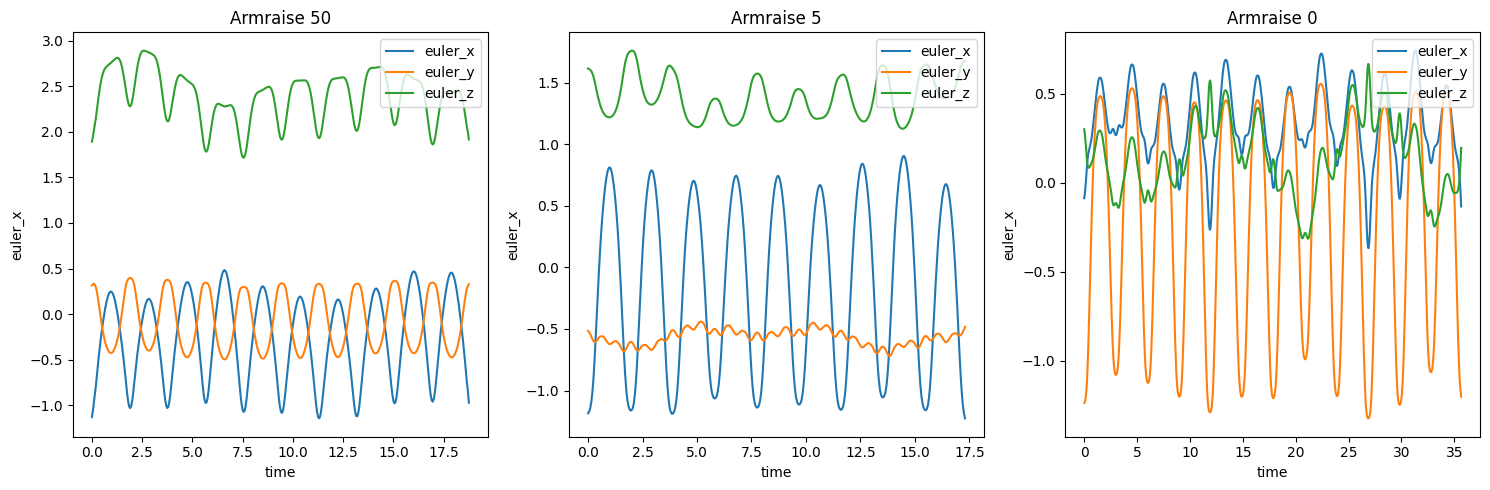

In [17]:
#plotting euler angles armraises

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Armraise 50')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Armraise 5')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Armraise 0')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()


In [88]:
# scales are different at this time, can I scale these? do I need to?

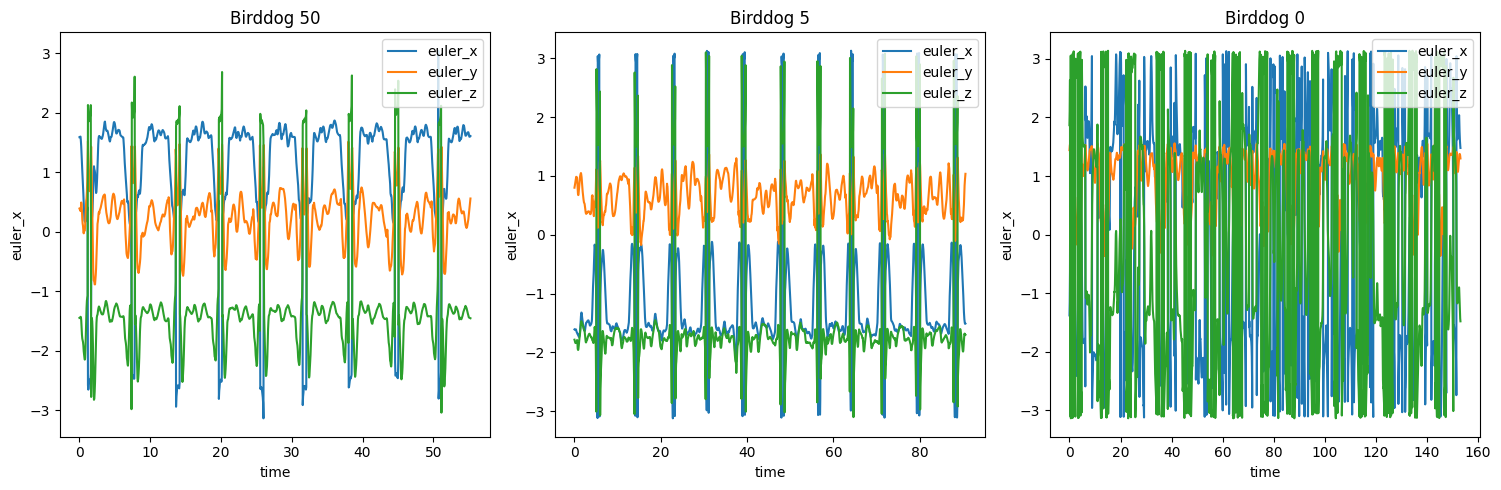

In [19]:
#plotting euler angles birddog

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Birddog 50')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Birddog 5')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Birddog 0')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()

In order to maintain an even amount of data from each set, I will take the smallest number of entries from all the datasets and use that number to take even spaced data from the longer datasets. For this test \
I used 25 rows, as at this point I thought that was close to my lowest number of rows per rep. I will soon be disappointed that this is not true.

In [89]:
dfx = birddog_dataframes[50]

In [75]:
#grabbing # rows/per rep

dfx_new = pd.DataFrame(columns = dfx.columns)

for rep in range(dfx['rep_num'].astype(int).max()):
    current_df = dfx[dfx['rep_num']==rep+1]
    count = current_df.shape[0]
    interval = count/25
    entry_list = []
    
    for i in range(25):
        entry_list.append(round(i*interval))
        
    dfx_new = pd.concat([dfx_new, current_df.iloc[entry_list].copy()], ignore_index=True)    

C:\Users\mufff\AppData\Local\Temp\ipykernel_2916\2336405398.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfx_new = pd.concat([dfx_new, current_df.iloc[entry_list].copy()], ignore_index=True)


In [78]:
dfx_new.shape

(225, 27)

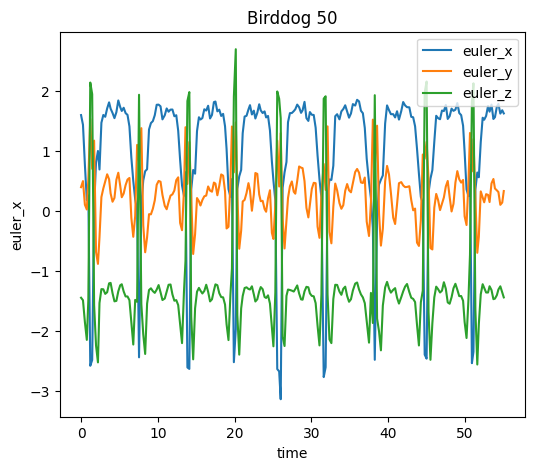

In [87]:
#looking to compare graph for dataset with reduced rows to above graph that includes all rows.They look the same to me, which is great!

fig, axes = plt.subplots(1, 1, figsize=(6, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=dfx_new, x="time", y="euler_x", label="euler_x")
sns.lineplot(data=dfx_new, x="time", y="euler_y", label="euler_y")
sns.lineplot(data=dfx_new, x="time", y="euler_z", label="euler_z")
axes.set_title('Birddog 50')
axes.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

Shortly after creating the functions to even out the dataset lengths by selecting a specific number of rows per rep, some errors notified me that 25 rows per rep was not attainable in all of the dataframes.\
There are 4 exercises containing reps with less than 25 rows. Crunches, hammercurls, overhead presses and tricep kickback left. I can easily use 10 rows per rep by only eliminating a few data sets from 2 exercises, and to 15 by eliminating more than a few more. Before I make that decision I want to take a peek at the plots to see if it makes a drastic different visually.

In [171]:
#viewing number of rows per rep in each data frame

from collections import defaultdict

row_counts = defaultdict(int)

for idx, df in enumerate(crunch_dataframes):
    # Count the number of rows for each repetition
    for rep_num, count in df['rep_num'].value_counts().items():
        row_counts[(idx, rep_num, count)] += 1

# Sort the results by the number of rows
sorted_row_counts = sorted(row_counts.items(), key=lambda x: x[0][2])

print("Repetitions Counted by Number of Rows (Sorted):")
for (df_idx, rep_num, count), repetition_count in sorted_row_counts:
    print(f"DataFrame {df_idx} - Rep Num {rep_num} with {count} rows: {repetition_count} occurrences")

Repetitions Counted by Number of Rows (Sorted):
DataFrame 22 - Rep Num 2.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 3.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 5.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 6.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 7.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 9.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 13.0 with 9 rows: 1 occurrences
DataFrame 33 - Rep Num 1.0 with 9 rows: 1 occurrences
DataFrame 33 - Rep Num 3.0 with 9 rows: 1 occurrences
DataFrame 33 - Rep Num 12.0 with 9 rows: 1 occurrences
DataFrame 52 - Rep Num 14.0 with 9 rows: 1 occurrences
DataFrame 55 - Rep Num 6.0 with 9 rows: 1 occurrences
DataFrame 22 - Rep Num 1.0 with 10 rows: 1 occurrences
DataFrame 22 - Rep Num 4.0 with 10 rows: 1 occurrences
DataFrame 22 - Rep Num 8.0 with 10 rows: 1 occurrences
DataFrame 22 - Rep Num 10.0 with 10 rows: 1 occurrences
DataFrame 22 - Rep Num 11.0 with 10 rows: 1 occurrences
DataFrame 22 - Rep Num 1

In [173]:
# function to grab and even selection of values from each exercise rep

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 25
        entry_list = []

        for i in range(25):
            entry_list.append(round(i * interval))

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new

In [181]:
#same function as above leaving accomodation for reps that don't meet the row requirement, which I don't really want to do. But I'm using it for now while I tinker with things.

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 10
        entry_list = []

        for i in range(10):
            rounded_value = round(i * interval)
            if rounded_value < count:
                entry_list.append(rounded_value)

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new

Turning this into a function to use on all datasets

In [97]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.")

In [182]:
#calling above function for each list of dataframes

#armraise_reduced = [data_reduction_dataframe(df) for df in armraise_dataframes]
#bicepcurl_reduced = [data_reduction_dataframe(df) for df in bicepcurl_dataframes]
birddog_reduced = [data_reduction_dataframe(df) for df in birddog_dataframes]
#burpee_reduced = [data_reduction_dataframe(df) for df in burpee_dataframes]
#crunch_reduced = [data_reduction_dataframe(df) for df in crunch_dataframes] #
#hammercurl_reduced = [data_reduction_dataframe(df) for df in hammercurl_dataframes] 
#overheadpress_reduced = [data_reduction_dataframe(df) for df in overheadpress_dataframes] #
#pushup_reduced = [data_reduction_dataframe(df) for df in pushup_dataframes] #
#tricepkickback_left_reduced = [data_reduction_dataframe(df) for df in tricepkickback_left_dataframes] #
#tricepkickback_right_reduced = [data_reduction_dataframe(df) for df in tricepkickback_right_dataframes]
#vup_reduced = [data_reduction_dataframe(df) for df in vup_dataframes]

In [183]:
bd15 = birddog_reduced[50]

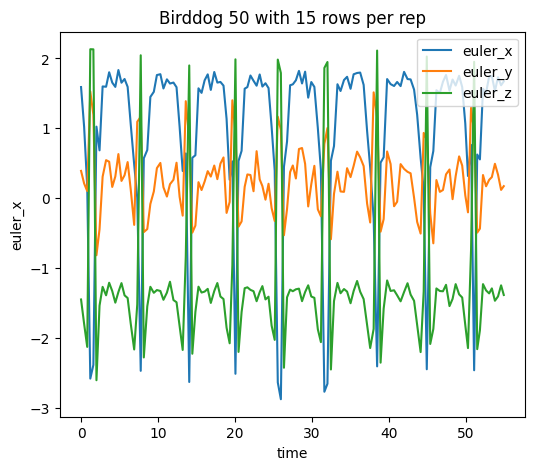

In [180]:
#plotting dataset with 15 rows per rep

fig, axes = plt.subplots(1, 1, figsize=(6, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=bd15, x="time", y="euler_x", label="euler_x")
sns.lineplot(data=bd15, x="time", y="euler_y", label="euler_y")
sns.lineplot(data=bd15, x="time", y="euler_z", label="euler_z")
axes.set_title('Birddog 50 with 15 rows per rep')
axes.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

There is definitely some detail lost moving down to 15.

In [184]:
bd10 = birddog_reduced[50]

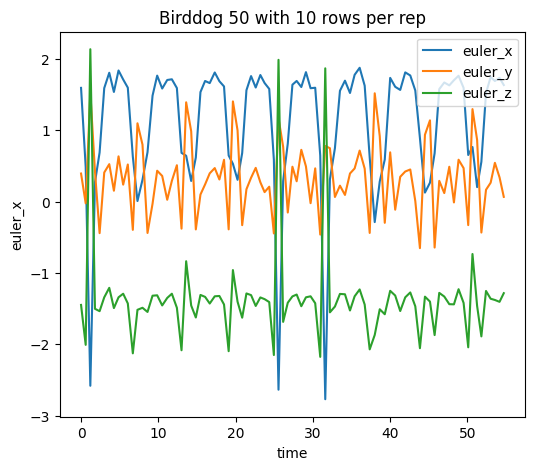

In [185]:
#plotting dataset with 10 rows per rep

fig, axes = plt.subplots(1, 1, figsize=(6, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=bd15, x="time", y="euler_x", label="euler_x")
sns.lineplot(data=bd15, x="time", y="euler_y", label="euler_y")
sns.lineplot(data=bd15, x="time", y="euler_z", label="euler_z")
axes.set_title('Birddog 50 with 10 rows per rep')
axes.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

Huge difference dropping down to 10 rows per rep. Definitely worth while putting more effort into trying to figure out a way to maintain a higher number of rows per rep.

In [151]:
#print the rows for the dataframe with the lowest number of rows. The lowest amount of rows in each grouping is 200.\

sorted_dataframes = sorted(enumerate(vup_reduced), key=lambda x: x[1].shape[0])

for i, (index, df) in enumerate(sorted_dataframes[:1]):
    print(f"DataFrame {index}: {df.shape[0]} rows")

DataFrame 18: 200 rows


testing to flatten data into one row

In [63]:
x = armraise_dataframes[0]
x2 = armraise_dataframes[0].iloc[:, 23:]

In [64]:
x2

,euler_x,euler_y,euler_z
0,-0.085816,-1.236302,0.301816
1,-0.068092,-1.232152,0.282132
2,-0.038189,-1.221286,0.252032
3,-0.001822,-1.203772,0.216632
4,0.042375,-1.174680,0.175925
5,0.086338,-1.130473,0.137707
6,0.122601,-1.069662,0.109276
7,0.149251,-0.992209,0.093229
8,0.168404,-0.899041,0.085828
9,0.182363,-0.792994,0.085705


In [55]:
#flatten dataframe into 1 row
x2.index = x2.index + 1
x2_out = x2.stack()
x2_out.index = x2_out.index.map('{0[1]}_{0[0]}'.format)
x2_out.to_frame().T

,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4,euler_x_5,euler_y_5,euler_z_5,euler_x_6,euler_y_6,euler_z_6,euler_x_7,euler_y_7,euler_z_7,euler_x_8,euler_y_8,euler_z_8,euler_x_9,euler_y_9,euler_z_9,euler_x_10,euler_y_10,euler_z_10,euler_x_11,euler_y_11,euler_z_11,euler_x_12,euler_y_12,euler_z_12,euler_x_13,euler_y_13,euler_z_13,euler_x_14,euler_y_14,euler_z_14,euler_x_15,euler_y_15,euler_z_15,euler_x_16,euler_y_16,euler_z_16,euler_x_17,euler_y_17,euler_z_17,euler_x_18,euler_y_18,euler_z_18,euler_x_19,euler_y_19,euler_z_19,euler_x_20,euler_y_20,euler_z_20,euler_x_21,euler_y_21,euler_z_21,euler_x_22,euler_y_22,euler_z_22,euler_x_23,euler_y_23,euler_z_23,euler_x_24,euler_y_24,euler_z_24,euler_x_25,euler_y_25,euler_z_25,euler_x_26,euler_y_26,euler_z_26,euler_x_27,euler_y_27,euler_z_27,euler_x_28,euler_y_28,euler_z_28,euler_x_29,euler_y_29,euler_z_29,euler_x_30,euler_y_30,euler_z_30,euler_x_31,euler_y_31,euler_z_31,euler_x_32,euler_y_32,euler_z_32,euler_x_33,euler_y_33,euler_z_33,euler_x_34,euler_y_34,euler_z_34,euler_x_35,euler_y_35,euler_z_35,euler_x_36,euler_y_36,euler_z_36,euler_x_37,euler_y_37,euler_z_37,euler_x_38,euler_y_38,euler_z_38,euler_x_39,euler_y_39,euler_z_39,euler_x_40,euler_y_40,euler_z_40,euler_x_41,euler_y_41,euler_z_41,euler_x_42,euler_y_42,euler_z_42,euler_x_43,euler_y_43,euler_z_43,euler_x_44,euler_y_44,euler_z_44,euler_x_45,euler_y_45,euler_z_45,euler_x_46,euler_y_46,euler_z_46,euler_x_47,euler_y_47,euler_z_47,euler_x_48,euler_y_48,euler_z_48,euler_x_49,euler_y_49,euler_z_49,euler_x_50,euler_y_50,euler_z_50,euler_x_51,euler_y_51,euler_z_51,euler_x_52,euler_y_52,euler_z_52,euler_x_53,euler_y_53,euler_z_53,euler_x_54,euler_y_54,euler_z_54,euler_x_55,euler_y_55,euler_z_55,euler_x_56,euler_y_56,euler_z_56,euler_x_57,euler_y_57,euler_z_57,euler_x_58,euler_y_58,euler_z_58,euler_x_59,euler_y_59,euler_z_59,euler_x_60,euler_y_60,euler_z_60,euler_x_61,euler_y_61,euler_z_61,euler_x_62,euler_y_62,euler_z_62,euler_x_63,euler_y_63,euler_z_63,euler_x_64,euler_y_64,euler_z_64,euler_x_65,euler_y_65,euler_z_65,euler_x_66,euler_y_66,euler_z_66,euler_x_67,euler_y_67,euler_z_67,euler_x_68,euler_y_68,euler_z_68,euler_x_69,euler_y_69,euler_z_69,euler_x_70,euler_y_70,euler_z_70,euler_x_71,euler_y_71,euler_z_71,euler_x_72,euler_y_72,euler_z_72,euler_x_73,euler_y_73,euler_z_73,euler_x_74,euler_y_74,euler_z_74,euler_x_75,euler_y_75,euler_z_75,euler_x_76,euler_y_76,euler_z_76,euler_x_77,euler_y_77,euler_z_77,euler_x_78,euler_y_78,euler_z_78,euler_x_79,euler_y_79,euler_z_79,euler_x_80,euler_y_80,euler_z_80,euler_x_81,euler_y_81,euler_z_81,euler_x_82,euler_y_82,euler_z_82,euler_x_83,euler_y_83,euler_z_83,euler_x_84,euler_y_84,euler_z_84,euler_x_85,euler_y_85,euler_z_85,euler_x_86,euler_y_86,euler_z_86,euler_x_87,euler_y_87,euler_z_87,euler_x_88,euler_y_88,euler_z_88,euler_x_89,euler_y_89,euler_z_89,euler_x_90,euler_y_90,euler_z_90,euler_x_91,euler_y_91,euler_z_91,euler_x_92,euler_y_92,euler_z_92,euler_x_93,euler_y_93,euler_z_93,euler_x_94,euler_y_94,euler_z_94,euler_x_95,euler_y_95,euler_z_95,euler_x_96,euler_y_96,euler_z_96,euler_x_97,euler_y_97,euler_z_97,euler_x_98,euler_y_98,euler_z_98,euler_x_99,euler_y_99,euler_z_99,euler_x_100,euler_y_100,euler_z_100,euler_x_101,euler_y_101,euler_z_101,euler_x_102,euler_y_102,euler_z_102,euler_x_103,euler_y_103,euler_z_103,euler_x_104,euler_y_104,euler_z_104,euler_x_105,euler_y_105,euler_z_105,euler_x_106,euler_y_106,euler_z_106,euler_x_107,euler_y_107,euler_z_107,euler_x_108,euler_y_108,euler_z_108,euler_x_109,euler_y_109,euler_z_109,euler_x_110,euler_y_110,euler_z_110,euler_x_111,euler_y_111,euler_z_111,euler_x_112,euler_y_112,euler_z_112,euler_x_113,euler_y_113,euler_z_113,euler_x_114,euler_y_114,euler_z_114,euler_x_115,euler_y_115,euler_z_115,euler_x_116,euler_y_116,euler_z_116,euler_x_117,euler_y_117,euler_z_117,euler_x_118,euler_y_118,euler_z_118,euler_x_119,euler_y_119,euler_z_119,euler_x_120,euler_y_120,euler_z_120,eul

## Learning about Fourier Transform

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/ \
https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101

In [20]:
import pandas as pd
import numpy as np
from scipy.fft import fft

df2 = armraise_dataframes[0]

euler_columns = ['euler_x', 'euler_y', 'euler_z']

# Apply Fourier transform to each column
for col in euler_columns:
    euler_array = np.ascontiguousarray(df2[col].values)
    
    df2[f'{col}_fft'] = np.abs(fft(euler_array))


In [21]:
df2

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,euler_x,euler_y,euler_z,euler_x_fft,euler_y_fft,euler_z_fft
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,4.818261,0.00,-0.085816,-1.236302,0.301816,233.448722,164.943182,104.794592
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,4.818261,0.05,-0.068092,-1.232152,0.282132,0.427206,5.311859,17.004060
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,4.818261,0.10,-0.038189,-1.221286,0.252032,11.860372,21.937540,60.676702
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,4.818261,0.15,-0.001822,-1.203772,0.216632,0.547906,14.878555,56.158340
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,4.818261,0.20,0.042375,-1.174680,0.175925,28.460837,16.318868,17.178685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.370983,11.897299,4.818261,35.45,0.068727,-1.028733,-0.003188,13.197612,1.616661,10.294815
710,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.387749,11.914065,4.818261,35.50,0.030103,-1.093677,0.032537,28.460837,16.318868,17.178685
711,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.404509,11.930825,4.818261,35.55,-0.010567,-1.139929,0.073019,0.547906,14.878555,56.158340
712,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.421261,11.947576,4.818261,35.60,-0.061702,-1.173829,0.124910,11.860372,21.937540,60.676702


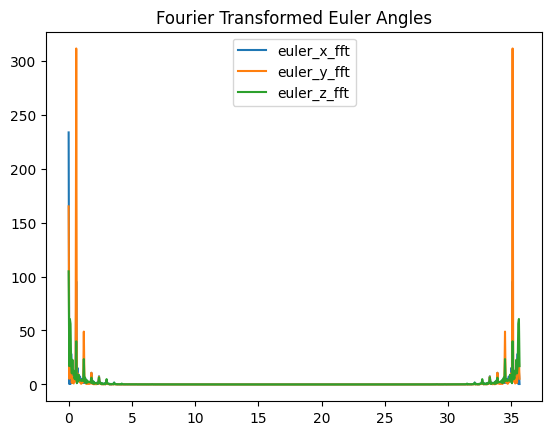

In [37]:
import matplotlib.pyplot as plt

# Assuming df2 is your DataFrame with Fourier-transformed columns
euler_fft_columns = ['euler_x_fft', 'euler_y_fft', 'euler_z_fft']

# Plot each Fourier-transformed column
for col in euler_fft_columns:
    plt.plot(df2['time'], df2[col], label=col)

plt.legend()
plt.title('Fourier Transformed Euler Angles')

# Show the plot
plt.show()

.